# Learning a Simple Linear Model with PyTorch

**Authors:** Jeffrey Huang and Alex Michels

In this notebook, we will use PyTorch for a simple linear regression model.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import time
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks

# Check PyTorch version
torch.__version__

'2.1.0+cu121'

This notebook is a quick overview of the general ML workflow.  In this scenario, we don't have data to start off with. After importing the necessary libraries, we instead create our own data that approximates a linear shape. This can be done using PyTorch's built in function for generating arrays, which are called tensors in an ML context.

In [2]:
# Create *known* parameters, our model will try to predict these
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

Next, it is necessary to split our generated dataset into training and validation sets. This is a necessary step in order to test the performance of model on data that it hasn't seen before, so called "out-of-sample" data. The normal ratio for a train test split is 80-20.

In [3]:
# Create random train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing
indices = np.random.permutation(X.shape[0]) # shuffle the data so our partitions are random
training_idx, test_idx = indices[:train_split], indices[train_split:]
X_train, y_train = X[training_idx, :], y[training_idx, :]
X_test, y_test = X[test_idx, :], y[test_idx, :]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

We can next define a function to help visualize the data. This is especially effective with data of simple dimensions that would be plotted on a 2D plane, such as our generated data. More complex, higher dimensional data may require some other form of representation.

In [4]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
    """
    Plots training data, test data and compares predictions.
    """
    plt.figure(figsize=(10, 7))
    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
    # Plot test data in green
    plt.scatter(test_data, test_labels, c="orange", s=4, label="Testing data")
    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
    # Show the legend
    plt.legend(prop={"size": 14});

We can test this function below. Understandably, we only see a straight line at first. The prediction points are not present yet because we haven't yet made a model for our data, let alone train or predict points with it.

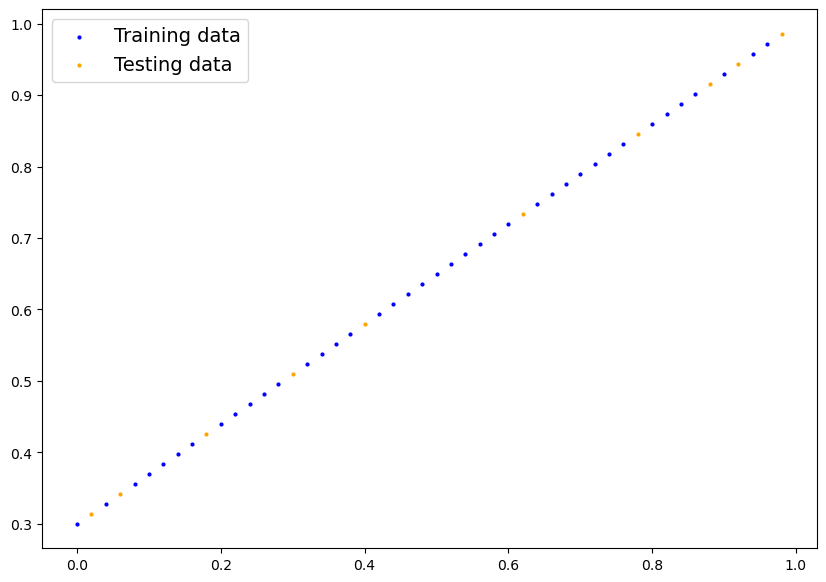

In [5]:
plot_predictions()

## Creating the Model

The next step is to define the model. As this is mostly linear data, the neural network for this simple; there isn't any complex architecture with many hidden layers. 

Instead, the model's weights and biases replicate the standard linear regression model. 

We also define a forward function for making a forward pass through the model. In more complex ML models this would be a function to let data go through every layer in the model to generate an output. Since this is a simple linear case, the forward function just plugs in an input x into weight and bias parameters.

In [6]:
# Create a Linear Regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
    def __init__(self):
        super().__init__() 
        self.weights = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
                                                dtype=torch.float), # <- PyTorch loves float32 by default
                                   requires_grad=True) # <- can we update this value with gradient descent?)

        self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
                                            dtype=torch.float), # <- PyTorch loves float32 by default
                                requires_grad=True) # <- can we update this value with gradient descent?))

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)

In [7]:
# Set manual seed since nn.Parameter are randomly initialzied
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = LinearRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

We can use the following syntax to make predictions with our model. Note that we haven't yet trained the model. Could you guess as to how well these predictions will perform? 

These will be terrible predictions because the model hasn't even seen the training data yet.

In [8]:
# Make predictions with model
with torch.inference_mode(): 
    y_preds = model_0(X_test)

In [9]:
print(f"Number of testing samples: {len(X_test)}") 
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.3914],
        [0.4588],
        [0.2635],
        [0.1355],
        [0.4386],
        [0.2298],
        [0.1490],
        [0.3376],
        [0.4251],
        [0.1894]])


We can plot our predictions to see that our model is very bad without training:

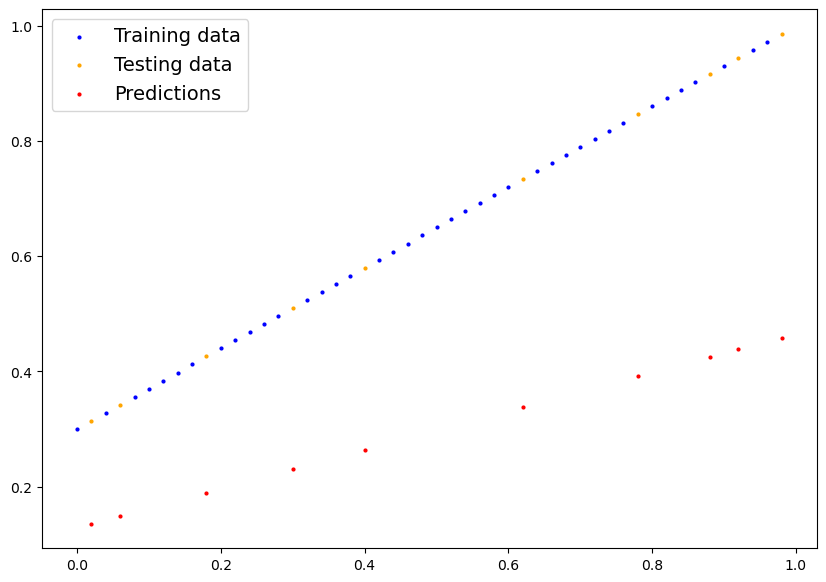

In [10]:
plot_predictions(predictions=y_preds)

## Training the Model

To prepare for the model training process, we additionally have to define a loss function and an optimizer. In this case we use the Mean Absolute Error (MAE) as our loss function.

$$MAE = \frac{\sum_{i=1}^{n}|y_{i}-x_{i}|}{n} = \frac{\sum_{i=1}^{n} |e_{i}|}{n}$$

where $y_{i}$ are the predictions, $x_{i}$ are the true values and $e_{i}$ is the error ($y_{i}-x_{i}$).


We will optimize with the [Stochastic Gradient Descent algorithm](https://en.wikipedia.org/wiki/Stochastic_gradient_descent).

In [11]:
# Create the loss function
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss

# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), # parameters of target model to optimize
                            lr=0.01) # learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time))

It's also good to check whether we are currently using CPU or GPU resources. Many ML tasks execute more efficiently on GPUs, and so it is worthwhile to execute this step. The following lines of code check if the current device PyTorch is running on is CPU or CUDA, along with more information. Depending on your system environment, this may change.

In [12]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cpu



Now begins the long awaited training step. We put together the functions we've defined previously iteratively feed the dataset through the model (each iteration is called an "epoch"). Over multiple iterations, the model parameters will be optimized. It is also worthwhile to see the time it takes for the model training step. As this is a simple linear model, training should be quick.

In [13]:
start_time = time.time()
torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 100

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training
    # Put model in training mode (this is the default state of a model)
    model_0.train()
    # 1. Forward pass on train data using the forward() method inside 
    y_pred = model_0(X_train)
    # print(y_pred)
    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)
    # 3. Zero grad of the optimizer
    optimizer.zero_grad()
    # 4. Loss backwards
    loss.backward()
    # 5. Progress the optimizer
    optimizer.step()
    ### Testing
    # Put the model in evaluation mode
    model_0.eval()
    with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = model_0(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

      # Print out what's happening
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")
curr_time = time.time()
print(f"Training took {curr_time - start_time} seconds")

Epoch: 0 | MAE Train Loss: 0.34703248739242554 | MAE Test Loss: 0.345443993806839 
Epoch: 10 | MAE Train Loss: 0.2236068695783615 | MAE Test Loss: 0.22056642174720764 
Epoch: 20 | MAE Train Loss: 0.10422110557556152 | MAE Test Loss: 0.10919070243835449 
Epoch: 30 | MAE Train Loss: 0.056145280599594116 | MAE Test Loss: 0.07201977074146271 
Epoch: 40 | MAE Train Loss: 0.04523301124572754 | MAE Test Loss: 0.06203325837850571 
Epoch: 50 | MAE Train Loss: 0.0405350998044014 | MAE Test Loss: 0.05537428334355354 
Epoch: 60 | MAE Train Loss: 0.03626192361116409 | MAE Test Loss: 0.04946230724453926 
Epoch: 70 | MAE Train Loss: 0.03198875114321709 | MAE Test Loss: 0.04355033114552498 
Epoch: 80 | MAE Train Loss: 0.02771509811282158 | MAE Test Loss: 0.037638384848833084 
Epoch: 90 | MAE Train Loss: 0.023439554497599602 | MAE Test Loss: 0.0317264162003994 
Training took 0.2305295467376709 seconds


Plotting the loss curves over epochs shows how loss decreases through each iteration, showing the model improving incrementally.

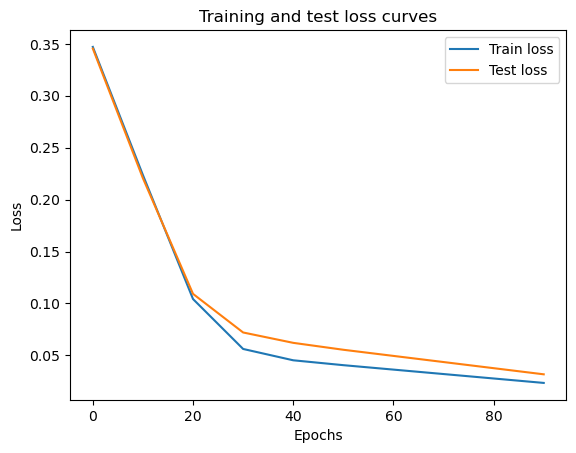

In [14]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [15]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.6178])), ('bias', tensor([0.3428]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


## Testing the Model

We can now evaluate the trained model. We see that it very nearly approximates the values in the testing set.

In [16]:
# 1. Set the model in evaluation mode
model_0.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  # 3. Make sure the calculations are done with the model and data on the same device
  # in our case, we haven't setup device-agnostic code yet so our data and model are
  # on the CPU by default.
  # model_0.to(device)
  # X_test = X_test.to(device)
  y_preds = model_0(X_test)
y_preds

tensor([[0.8247],
        [0.9482],
        [0.5899],
        [0.3552],
        [0.9112],
        [0.5281],
        [0.3799],
        [0.7258],
        [0.8864],
        [0.4540]])

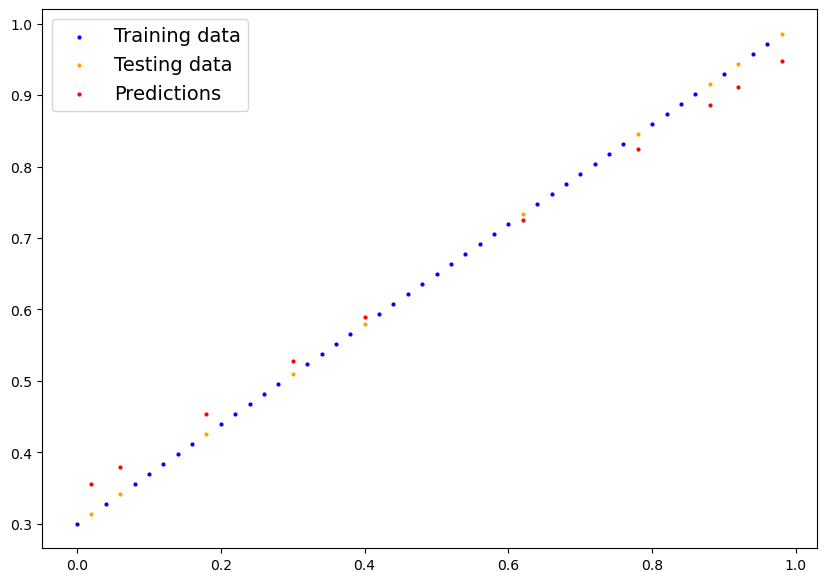

In [17]:
plot_predictions(predictions=y_preds)

## Saving the Trained Model

Lastly, we can save the trained model. We can either save the entire model or just its state_dict (its parameters). The latter is the safer option in most cases.

In [18]:
# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [19]:
# Check the saved file path
!ls -l models/01_pytorch_workflow_model_0.pth

-rw-r--r-- 1 jovyan users 1680 Nov  7 20:37 models/01_pytorch_workflow_model_0.pth


In [20]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = LinearRegressionModel()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [21]:
# 1. Put the loaded model into evaluation mode
loaded_model_0.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test) # perform a forward pass on the test data with the loaded model

In [22]:
# Compare previous model predictions with loaded model predictions (these should be the same)
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])